# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [2]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)




Xtrain1 = train_set[0]
Ttrain1 = train_set[1].reshape(-1, 1)

Xval1 = valid_set[0]
Tval1 = valid_set[1].reshape(-1, 1)

Xtest1 = test_set[0]
Ttest1 = test_set[1].reshape(-1, 1)

Xtrain1 = Xtrain1.reshape(-1, 1, 28, 28)
Xtest1 = Xtest1.reshape(-1, 1, 28, 28)





Xtrain2 = train_set[0]
Ttrain2 = train_set[1].reshape(-1, 1)

Xval2 = valid_set[0]
Tval2 = valid_set[1].reshape(-1, 1)

Xtest2 = test_set[0]
Ttest2 = test_set[1].reshape(-1, 1)

Xtrain2 = Xtrain2.reshape(-1, 1, 28, 28)
Xtest2 = Xtest2.reshape(-1, 1, 28, 28)





Xtrain3 = train_set[0]
Ttrain3 = train_set[1].reshape(-1, 1)

Xval3 = valid_set[0]
Tval3 = valid_set[1].reshape(-1, 1)

Xtest3 = test_set[0]
Ttest3 = test_set[1].reshape(-1, 1)

Xtrain3 = Xtrain3.reshape(-1, 1, 28, 28)
Xtest3 = Xtest3.reshape(-1, 1, 28, 28)





Xtrain4 = train_set[0]
Ttrain4 = train_set[1].reshape(-1, 1)

Xval4 = valid_set[0]
Tval4 = valid_set[1].reshape(-1, 1)

Xtest4 = test_set[0]
Ttest4 = test_set[1].reshape(-1, 1)

Xtrain4 = Xtrain4.reshape(-1, 1, 28, 28)
Xtest4 = Xtest4.reshape(-1, 1, 28, 28)




Xtrain5 = train_set[0]
Ttrain5 = train_set[1].reshape(-1, 1)

Xval5 = valid_set[0]
Tval5 = valid_set[1].reshape(-1, 1)

Xtest5 = test_set[0]
Ttest5 = test_set[1].reshape(-1, 1)

Xtrain5 = Xtrain5.reshape(-1, 1, 28, 28)
Xtest5 = Xtest5.reshape(-1, 1, 28, 28)




Xtrain6 = train_set[0]
Ttrain6 = train_set[1].reshape(-1, 1)

Xval6 = valid_set[0]
Tval6 = valid_set[1].reshape(-1, 1)

Xtest6 = test_set[0]
Ttest6 = test_set[1].reshape(-1, 1)

Xtrain6 = Xtrain6.reshape(-1, 1, 28, 28)
Xtest6 = Xtest6.reshape(-1, 1, 28, 28)


print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


/usr/local/anaconda3/latest/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.475
adam: Epoch 4 Loss 0.322
adam: Epoch 6 Loss 0.270
adam: Epoch 8 Loss 0.242
adam: Epoch 10 Loss 0.226
adam: Epoch 12 Loss 0.212
adam: Epoch 14 Loss 0.204
adam: Epoch 16 Loss 0.194
adam: Epoch 18 Loss 0.188
adam: Epoch 20 Loss 0.188
adam: Epoch 2 Loss 0.724
adam: Epoch 4 Loss 0.590
adam: Epoch 6 Loss 0.523
adam: Epoch 8 Loss 0.494
adam: Epoch 10 Loss 0.472
adam: Epoch 12 Loss 0.451
adam: Epoch 14 Loss 0.420
adam: Epoch 16 Loss 0.419
adam: Epoch 18 Loss 0.387
adam: Epoch 20 Loss 0.379
adam: Epoch 2 Loss 0.704
adam: Epoch 4 Loss 0.529
adam: Epoch 6 Loss 0.435
adam: Epoch 8 Loss 0.409
adam: Epoch 10 Loss 0.361
adam: Epoch 12 Loss 0.377
adam: Epoch 14 Loss 0.340
adam: Epoch 16 Loss 0.339
adam: Epoch 18 Loss 0.330
adam: Epoch 20 Loss 0.327
adam: Epoch 2 Loss 0.614
adam: Epoch 4 Loss 0.391
adam: Epoch 6 Loss 0.348
adam: Epoch 8 Loss 0.318
adam: Epoch 10 Loss 0.316
adam: Epoch 12 Loss 0.295
adam: Epoch 14 Loss 0.290
adam: Epoch 16 Loss 0.278
adam: Epoch 18 Loss 0.269
ad

Text(0.5, 1.0, 'MNIST')

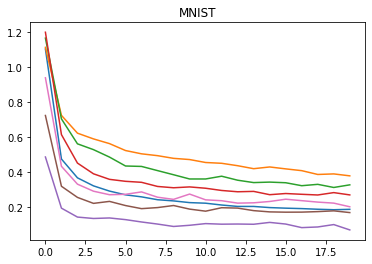

In [6]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')





n_hiddens_per_conv_layer1 = [10]
patch_size_per_conv_layer1 = [5]
stride_per_conv_layer1=[1]
n_hiddens_per_fc_layer1 = [5]

cnnet1 = CNN2D(28 * 28, n_hiddens_per_conv_layer1, n_hiddens_per_fc_layer1, len(np.unique(Ttrain1)), 
              patch_size_per_conv_layer1, stride_per_conv_layer1, device=device)

cnnet1.train(Xtrain1, Ttrain1, batch_size, n_epochs, learning_rate, method='adam')






n_hiddens_per_conv_layer2 = [10, 10]
patch_size_per_conv_layer2 = [5, 5]
stride_per_conv_layer2=[1, 1]
n_hiddens_per_fc_layer2 = [5]

cnnet2 = CNN2D(28 * 28, n_hiddens_per_conv_layer2, n_hiddens_per_fc_layer2, len(np.unique(Ttrain2)), 
              patch_size_per_conv_layer2, stride_per_conv_layer2, device=device)

cnnet2.train(Xtrain2, Ttrain2, batch_size, n_epochs, learning_rate, method='adam')






n_hiddens_per_conv_layer3 = [10, 10, 10]
patch_size_per_conv_layer3 = [5, 5, 5]
stride_per_conv_layer3=[1, 1, 1]
n_hiddens_per_fc_layer3 = [5]

cnnet3 = CNN2D(28 * 28, n_hiddens_per_conv_layer3, n_hiddens_per_fc_layer3, len(np.unique(Ttrain3)), 
              patch_size_per_conv_layer3, stride_per_conv_layer3, device=device)

cnnet3.train(Xtrain3, Ttrain3, batch_size, n_epochs, learning_rate, method='adam')

'''
Step2: Using the best number of convolutional layers found in Step 1, compare the test accuracies 
of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.
'''

n_hiddens_per_conv_layer4 = [10, 10, 10]
patch_size_per_conv_layer4 = [5, 5, 5]
stride_per_conv_layer4=[1, 1, 1]
n_hiddens_per_fc_layer4 = []

cnnet4 = CNN2D(28 * 28, n_hiddens_per_conv_layer4, n_hiddens_per_fc_layer4, len(np.unique(Ttrain4)), 
              patch_size_per_conv_layer4, stride_per_conv_layer4, device=device)

cnnet4.train(Xtrain4, Ttrain4, batch_size, n_epochs, learning_rate, method='adam')








n_hiddens_per_conv_layer5 = [10, 10, 10]
patch_size_per_conv_layer5 = [5, 5, 5]
stride_per_conv_layer5=[1, 1, 1]
n_hiddens_per_fc_layer5 = [10]

cnnet5 = CNN2D(28 * 28, n_hiddens_per_conv_layer5, n_hiddens_per_fc_layer5, len(np.unique(Ttrain5)), 
              patch_size_per_conv_layer5, stride_per_conv_layer5, device=device)

cnnet5.train(Xtrain5, Ttrain5, batch_size, n_epochs, learning_rate, method='adam')







n_hiddens_per_conv_layer6 = [10, 10, 10]
patch_size_per_conv_layer6 = [5, 5, 5]
stride_per_conv_layer6=[1, 1, 1]
n_hiddens_per_fc_layer6 = [10, 10]

cnnet6 = CNN2D(28 * 28, n_hiddens_per_conv_layer6, n_hiddens_per_fc_layer6, len(np.unique(Ttrain6)), 
              patch_size_per_conv_layer6, stride_per_conv_layer6, device=device)

cnnet6.train(Xtrain6, Ttrain6, batch_size, n_epochs, learning_rate, method='adam')




plt.plot(cnnet.error_trace, label='Pytorch')

'''Step1'''
plt.plot(cnnet1.error_trace, label='Pytorch')
plt.plot(cnnet2.error_trace, label='Pytorch')
plt.plot(cnnet3.error_trace, label='Pytorch')

'''Step2'''
plt.plot(cnnet4.error_trace, label='Pytorch')
plt.plot(cnnet5.error_trace, label='Pytorch')
plt.plot(cnnet6.error_trace, label='Pytorch')

plt.title('MNIST')

In [7]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [8]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')


result1=[]


Classes1, _ = cnnet1.use(Xtrain1)
Classes2, _ = cnnet1.use(Xtest1)

result1.append([n_hiddens_per_conv_layer1,
                n_hiddens_per_fc_layer1,
                100 * np.mean(Classes1 == Ttrain1),
                100 * np.mean(Classes2 == Ttest1),
                patch_size_per_conv_layer1,
                stride_per_conv_layer1])






Classes3, _ = cnnet2.use(Xtrain2)
Classes4, _ = cnnet2.use(Xtest2)

result1.append([n_hiddens_per_conv_layer2,
                n_hiddens_per_fc_layer2,
                100 * np.mean(Classes3 == Ttrain2),
                100 * np.mean(Classes4 == Ttest2),
                patch_size_per_conv_layer2,
                stride_per_conv_layer2])






Classes5, _ = cnnet3.use(Xtrain3)
Classes6, _ = cnnet3.use(Xtest3)

result1.append([n_hiddens_per_conv_layer3,
                n_hiddens_per_fc_layer3,
                100 * np.mean(Classes5 == Ttrain3),
                100 * np.mean(Classes6 == Ttest3),
                patch_size_per_conv_layer3,
                stride_per_conv_layer3])







Classes7, _ = cnnet4.use(Xtrain4)
Classes8, _ = cnnet4.use(Xtest4)

result1.append([n_hiddens_per_conv_layer4,
                n_hiddens_per_fc_layer4,
                100 * np.mean(Classes7 == Ttrain4),
                100 * np.mean(Classes8 == Ttest4),
                patch_size_per_conv_layer4,
                stride_per_conv_layer4])






Classes9, _ = cnnet5.use(Xtrain5)
Classes10, _ = cnnet5.use(Xtest5)

result1.append([n_hiddens_per_conv_layer5,
                n_hiddens_per_fc_layer5,
                100 * np.mean(Classes9 == Ttrain5),
                100 * np.mean(Classes10 == Ttest5),
                patch_size_per_conv_layer5,
                stride_per_conv_layer5])





Classes11, _ = cnnet6.use(Xtrain6)
Classes12, _ = cnnet6.use(Xtest6)

result1.append([n_hiddens_per_conv_layer6,
                n_hiddens_per_fc_layer6,
                100 * np.mean(Classes11 == Ttrain6),
                100 * np.mean(Classes12 == Ttest6),
                patch_size_per_conv_layer6,
                stride_per_conv_layer6])





df1 = pandas.DataFrame(result1, columns=('Convo. Layers', 'FC Layers', 'Train', 'Test', 'Patches', 'Strides'))


df1

Test accuracy in percent correct: 93.48


,Convo. Layers,FC Layers,Train,Test,Patches,Strides
0,[10],[5],89.066,89.48,[5],[1]
1,"[10, 10]",[5],93.286,93.04,"[5, 5]","[1, 1]"
2,"[10, 10, 10]",[5],94.306,94.77,"[5, 5, 5]","[1, 1, 1]"
3,"[10, 10, 10]",[],99.204,98.15,"[5, 5, 5]","[1, 1, 1]"
4,"[10, 10, 10]",[10],94.976,94.96,"[5, 5, 5]","[1, 1, 1]"
5,"[10, 10, 10]","[10, 10]",93.006,93.35,"[5, 5, 5]","[1, 1, 1]"


#### Discuss your results, and describe the network structure and training parameters that produced the best test results.

 
# ANSWER
### When running the first set of expirements, all the hyperparameters were essentially the same. The only difference is that the number of convolutional layers changed by increments of one. With each added convolutional layer, the percent correct on the train and test sets increased between 1% - 4%. This means that the more convolutional layers added, the better the results did in the network. Therefore, the network with the 3 convolutional layers was the best because this was the maximum number of conovolutional layers used on all expirements. This is as expected. Wht convolutional networks in this expirement does is it detects patterns in images. Each nested convolutinal layer that gets added becomes more complex and can extract/learn more information/patterns from the images. Therefore, the more layers are added the more learning that can be made by the network because it can detect a variety of patterns within the image. Also, the confusion matrix produced by each expirement was very good. Only a few percentages within the matrix diagonal were below 90%. This is probably due to the fact that the dataset is not too complex. If it were more complex then the expirement with only one convolutional layer would produce significantly worse results then it did. 

### So it is established that the best convolutional neural network from the expirements was the network with the 3 convolutional layers. Then we ran expirements with the same hyperparameters from the best neural network. With a slight modification. We changed the number of fully-connected layers. Each fully-connected layer had a size of 10, except for the empty set. These expirements produced the opposite of what the expirements in step 1 did. Instead of the percent correct improving as each layer was added, the pereentages actually got worse. Therefore the network with the empty set for the fully-connected layer parameter, out-performed the rest. The reason I believe this occurs is becuase we are using a simple dataset. There is not much complexity so if we add more fully-connected layers we are over-learning the data. Hence producing worse results because of information overload on a simple dataset.




## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [9]:
class CNN1D(CNN2D):
    
    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
             patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
             patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu')

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)

        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):

        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(n_inputs)  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [10]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [11]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

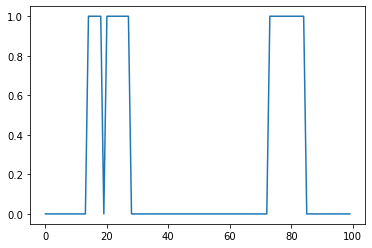

In [12]:
plt.plot(square_pulse)

In [13]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [14]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.        , 0.5       , 1.        , 1.        ,
       0.5       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        , 1.        , 0.85714286,
       0.71428571, 0.57142857, 0.42857143, 0.28571429, 0.14285714,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2       , 0.4       , 0.6       ,
       0.8       , 1.        , 1.        , 0.8       , 0.6       ,
       0.4       , 0.2       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

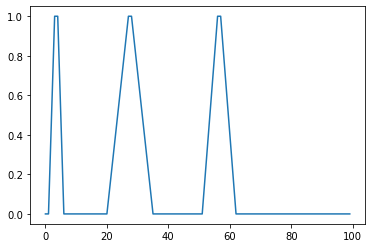

In [15]:
plt.plot(triangular_pulse)

In [16]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [17]:
np.newaxis == None

True

In [18]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [19]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.584
adam: Epoch 20 Loss 0.362
adam: Epoch 30 Loss 0.174
adam: Epoch 40 Loss 0.039
adam: Epoch 50 Loss 0.012
adam: Epoch 60 Loss 0.002
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.000
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

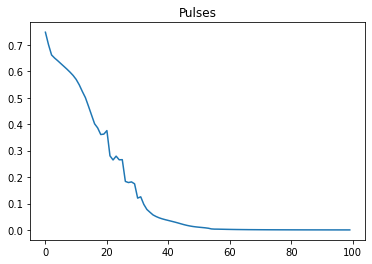

In [20]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [21]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 98.90


,square,triangular
square,97.8,2.2
triangular,0.0,100.0


torch.Size([10, 10])

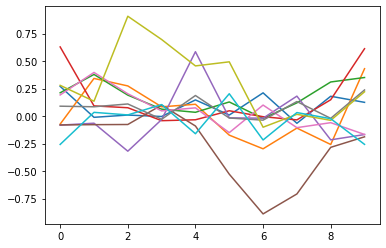

In [22]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [23]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

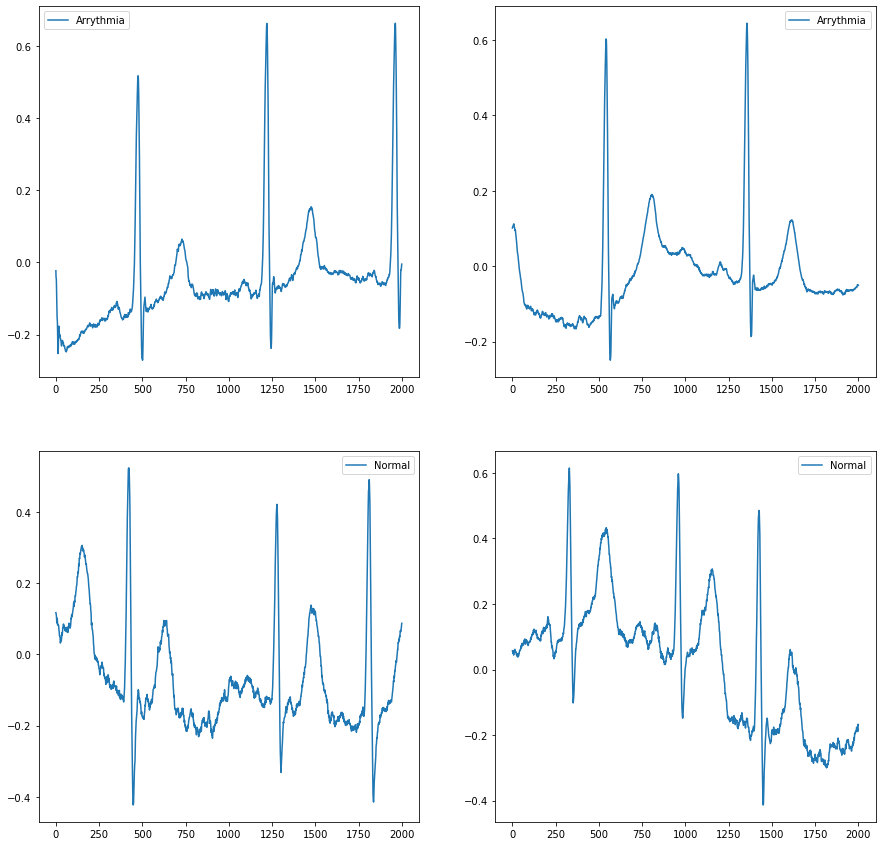

In [24]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [25]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)

n_train = int(n_samples * 0.8)

Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain_1 = X[rows[:n_train], ...]
Ttrain_1 = T[rows[:n_train], ...]
Xtest_1 = X[rows[n_train:], ...]
Ttest_1 = T[rows[n_train:], ...]

Xtrain_2 = X[rows[:n_train], ...]
Ttrain_2 = T[rows[:n_train], ...]
Xtest_2 = X[rows[n_train:], ...]
Ttest_2 = T[rows[n_train:], ...]

Xtrain_3 = X[rows[:n_train], ...]
Ttrain_3 = T[rows[:n_train], ...]
Xtest_3 = X[rows[n_train:], ...]
Ttest_3 = T[rows[n_train:], ...]

Xtrain_4 = X[rows[:n_train], ...]
Ttrain_4 = T[rows[:n_train], ...]
Xtest_4 = X[rows[n_train:], ...]
Ttest_4 = T[rows[n_train:], ...]

Xtrain_5 = X[rows[:n_train], ...]
Ttrain_5 = T[rows[:n_train], ...]
Xtest_5 = X[rows[n_train:], ...]
Ttest_5 = T[rows[n_train:], ...]

Xtrain_6 = X[rows[:n_train], ...]
Ttrain_6 = T[rows[:n_train], ...]
Xtest_6 = X[rows[n_train:], ...]
Ttest_6 = T[rows[n_train:], ...]

Xtrain_7 = X[rows[:n_train], ...]
Ttrain_7 = T[rows[:n_train], ...]
Xtest_7 = X[rows[n_train:], ...]
Ttest_7 = T[rows[n_train:], ...]

Xtrain_8 = X[rows[:n_train], ...]
Ttrain_8 = T[rows[:n_train], ...]
Xtest_8 = X[rows[n_train:], ...]
Ttest_8 = T[rows[n_train:], ...]

Xtrain_9 = X[rows[:n_train], ...]
Ttrain_9 = T[rows[:n_train], ...]
Xtest_9 = X[rows[n_train:], ...]
Ttest_9 = T[rows[n_train:], ...]

Xtrain_10 = X[rows[:n_train], ...]
Ttrain_10 = T[rows[:n_train], ...]
Xtest_10 = X[rows[n_train:], ...]
Ttest_10 = T[rows[n_train:], ...]


Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [26]:
Ttrain

array([['nr'],
       ['nr'],
       ['nr'],
       ...,
       ['arr'],
       ['arr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [27]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

'''
n_hiddens_per_conv_layer = [5, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [10, 10]

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)
'''

result1=[]



n_hiddens_per_conv_layer1 = [10]
patch_size_per_conv_layer1 = [5]
stride_per_conv_layer1 = [1]
n_hiddens_per_fc_layer1 = []

cnn1d_1 = CNN1D(Xtrain_1.shape[-1], n_hiddens_per_conv_layer1, n_hiddens_per_fc_layer1, 2, 
              patch_size_per_conv_layer1, stride_per_conv_layer1, device=device)

n_epochs_1 = 100
batch_size_1 = 10
learning_rate_1 = 0.001

cnn1d_1.train(Xtrain_1, Ttrain_1, batch_size_1, n_epochs_1, learning_rate_1, method='adam')

Classes1, _ = cnn1d_1.use(Xtrain_1)
Classes2, _ = cnn1d_1.use(Xtest_1)

result1.append([n_hiddens_per_conv_layer1,
                n_hiddens_per_fc_layer1,
                100 * np.mean(Classes1 == Ttrain_1),
                100 * np.mean(Classes2 == Ttest_1),
                patch_size_per_conv_layer1,
                stride_per_conv_layer1])






n_hiddens_per_conv_layer2 = [5, 10]
patch_size_per_conv_layer2 = [100, 20]
stride_per_conv_layer2 = [20, 5]
n_hiddens_per_fc_layer2 = [10, 10]

cnn1d_2 = CNN1D(Xtrain_2.shape[-1], n_hiddens_per_conv_layer2, n_hiddens_per_fc_layer2, 2, 
              patch_size_per_conv_layer2, stride_per_conv_layer2, device=device)

n_epochs_2 = 100
batch_size_2 = 10
learning_rate_2 = 0.001

cnn1d_2.train(Xtrain_2, Ttrain_2, batch_size_2, n_epochs_2, learning_rate_2, method='adam')

Classes3, _ = cnn1d_2.use(Xtrain_2)
Classes4, _ = cnn1d_2.use(Xtest_2)

result1.append([n_hiddens_per_conv_layer2,
                n_hiddens_per_fc_layer2,
                100 * np.mean(Classes3 == Ttrain_2),
                100 * np.mean(Classes4 == Ttest_2),
                patch_size_per_conv_layer2,
                stride_per_conv_layer2])







n_hiddens_per_conv_layer3 = [5, 10, 10]
patch_size_per_conv_layer3 = [100, 20, 10]
stride_per_conv_layer3 = [20, 5, 5]
n_hiddens_per_fc_layer3 = [10, 10, 10]

cnn1d_3 = CNN1D(Xtrain_3.shape[-1], n_hiddens_per_conv_layer3, n_hiddens_per_fc_layer3, 2, 
              patch_size_per_conv_layer3, stride_per_conv_layer3, device=device)

n_epochs_3 = 100
batch_size_3 = 10
learning_rate_3 = 0.001

cnn1d_3.train(Xtrain_3, Ttrain_3, batch_size_3, n_epochs_3, learning_rate_3, method='adam')

Classes5, _ = cnn1d_3.use(Xtrain_3)
Classes6, _ = cnn1d_3.use(Xtest_3)

result1.append([n_hiddens_per_conv_layer3,
                n_hiddens_per_fc_layer3,
                100 * np.mean(Classes5 == Ttrain_3),
                100 * np.mean(Classes6 == Ttest_3),
                patch_size_per_conv_layer3,
                stride_per_conv_layer3])








n_hiddens_per_conv_layer4 = [5, 10, 20]
patch_size_per_conv_layer4 = [100, 20, 10]
stride_per_conv_layer4 = [20, 5, 10]
n_hiddens_per_fc_layer4 = [10, 10, 10]

cnn1d_4 = CNN1D(Xtrain_4.shape[-1], n_hiddens_per_conv_layer4, n_hiddens_per_fc_layer4, 2, 
              patch_size_per_conv_layer4, stride_per_conv_layer4, device=device)

n_epochs_4 = 100
batch_size_4 = 10
learning_rate_4 = 0.001

cnn1d_4.train(Xtrain_4, Ttrain_4, batch_size_4, n_epochs_4, learning_rate_4, method='adam')

Classes7, _ = cnn1d_4.use(Xtrain_4)
Classes8, _ = cnn1d_4.use(Xtest_4)

result1.append([n_hiddens_per_conv_layer4,
                n_hiddens_per_fc_layer4,
                100 * np.mean(Classes7 == Ttrain_4),
                100 * np.mean(Classes8 == Ttest_4),
                patch_size_per_conv_layer4,
                stride_per_conv_layer4])







n_hiddens_per_conv_layer5 = [5]
patch_size_per_conv_layer5 = [100]
stride_per_conv_layer5 = [20]
n_hiddens_per_fc_layer5 = [10]

cnn1d_5 = CNN1D(Xtrain_5.shape[-1], n_hiddens_per_conv_layer5, n_hiddens_per_fc_layer5, 2, 
              patch_size_per_conv_layer5, stride_per_conv_layer5, device=device)

n_epochs_5 = 100
batch_size_5 = 10
learning_rate_5 = 0.001

cnn1d_5.train(Xtrain_5, Ttrain_5, batch_size_5, n_epochs_5, learning_rate_5, method='adam')

Classes9, _ = cnn1d_5.use(Xtrain_5)
Classes10, _ = cnn1d_5.use(Xtest_5)

result1.append([n_hiddens_per_conv_layer5,
                n_hiddens_per_fc_layer5,
                100 * np.mean(Classes9 == Ttrain_5),
                100 * np.mean(Classes10 == Ttest_5),
                patch_size_per_conv_layer5,
                stride_per_conv_layer5])








n_hiddens_per_conv_layer6 = [10, 10]
patch_size_per_conv_layer6 = [100, 80]
stride_per_conv_layer6 = [20, 20]
n_hiddens_per_fc_layer6 = [10, 10]

cnn1d_6 = CNN1D(Xtrain_6.shape[-1], n_hiddens_per_conv_layer6, n_hiddens_per_fc_layer6, 2, 
              patch_size_per_conv_layer6, stride_per_conv_layer6, device=device)

n_epochs_6 = 100
batch_size_6 = 10
learning_rate_6 = 0.001

cnn1d_6.train(Xtrain_6, Ttrain_6, batch_size_6, n_epochs_6, learning_rate_6, method='adam')

Classes11, _ = cnn1d_6.use(Xtrain_6)
Classes12, _ = cnn1d_6.use(Xtest_6)

result1.append([n_hiddens_per_conv_layer6,
                n_hiddens_per_fc_layer6,
                100 * np.mean(Classes11 == Ttrain_6),
                100 * np.mean(Classes12 == Ttest_6),
                patch_size_per_conv_layer6,
                stride_per_conv_layer6])






n_hiddens_per_conv_layer7 = [80, 80, 40]
patch_size_per_conv_layer7 = [40, 20, 1]
stride_per_conv_layer7 = [100, 100, 80]
n_hiddens_per_fc_layer7 = [10, 10, 10]

cnn1d_7 = CNN1D(Xtrain_7.shape[-1], n_hiddens_per_conv_layer7, n_hiddens_per_fc_layer7, 2, 
              patch_size_per_conv_layer7, stride_per_conv_layer7, device=device)

n_epochs_7 = 100
batch_size_7 = 10
learning_rate_7 = 0.001

cnn1d_7.train(Xtrain_7, Ttrain_7, batch_size_7, n_epochs_7, learning_rate_7, method='adam')

Classes13, _ = cnn1d_7.use(Xtrain_7)
Classes14, _ = cnn1d_7.use(Xtest_7)

result1.append([n_hiddens_per_conv_layer7,
                n_hiddens_per_fc_layer7,
                100 * np.mean(Classes13 == Ttrain_7),
                100 * np.mean(Classes14 == Ttest_7),
                patch_size_per_conv_layer7,
                stride_per_conv_layer7])




n_hiddens_per_conv_layer8 = [10, 10, 10]
patch_size_per_conv_layer8 = [100, 50, 3]
stride_per_conv_layer8 = [20, 20, 20]
n_hiddens_per_fc_layer8 = [10, 10, 10]

cnn1d_8 = CNN1D(Xtrain_8.shape[-1], n_hiddens_per_conv_layer8, n_hiddens_per_fc_layer8, 2, 
              patch_size_per_conv_layer8, stride_per_conv_layer8, device=device)

n_epochs_8 = 100
batch_size_8 = 10
learning_rate_8 = 0.001

cnn1d_8.train(Xtrain_8, Ttrain_8, batch_size_8, n_epochs_8, learning_rate_8, method='adam')

Classes15, _ = cnn1d_8.use(Xtrain_8)
Classes16, _ = cnn1d_8.use(Xtest_8)

result1.append([n_hiddens_per_conv_layer8,
                n_hiddens_per_fc_layer8,
                100 * np.mean(Classes15 == Ttrain_8),
                100 * np.mean(Classes16 == Ttest_8),
                patch_size_per_conv_layer8,
                stride_per_conv_layer8])








n_hiddens_per_conv_layer9 = [10, 20, 40]
patch_size_per_conv_layer9 = [10, 40, 20]
stride_per_conv_layer9 = [5, 10, 20]
n_hiddens_per_fc_layer9 = [5, 5, 5]

cnn1d_9 = CNN1D(Xtrain_9.shape[-1], n_hiddens_per_conv_layer9, n_hiddens_per_fc_layer9, 2, 
              patch_size_per_conv_layer9, stride_per_conv_layer9, device=device)

n_epochs_9 = 100
batch_size_9 = 10
learning_rate_9 = 0.001

cnn1d_9.train(Xtrain_9, Ttrain_9, batch_size_9, n_epochs_9, learning_rate_9, method='adam')

Classes17, _ = cnn1d_9.use(Xtrain_9)
Classes18, _ = cnn1d_9.use(Xtest_9)

result1.append([n_hiddens_per_conv_layer9,
                n_hiddens_per_fc_layer9,
                100 * np.mean(Classes17 == Ttrain_9),
                100 * np.mean(Classes18 == Ttest_9),
                patch_size_per_conv_layer9,
                stride_per_conv_layer9])





n_hiddens_per_conv_layer10 = [5, 10, 5]
patch_size_per_conv_layer10 = [100, 20, 5]
stride_per_conv_layer10 = [20, 5, 20]
n_hiddens_per_fc_layer10 = [10, 10, 10]


cnn1d_10 = CNN1D(Xtrain_10.shape[-1], n_hiddens_per_conv_layer10, n_hiddens_per_fc_layer10, 2, 
              patch_size_per_conv_layer10, stride_per_conv_layer10, device=device)

n_epochs_10 = 100
batch_size_10 = 10
learning_rate_10 = 0.001

cnn1d_10.train(Xtrain_10, Ttrain_10, batch_size_10, n_epochs_10, learning_rate_10, method='adam')

Classes19, _ = cnn1d_10.use(Xtrain_10)
Classes20, _ = cnn1d_10.use(Xtest_10)

result1.append([n_hiddens_per_conv_layer10,
                n_hiddens_per_fc_layer10,
                100 * np.mean(Classes19 == Ttrain_10),
                100 * np.mean(Classes20 == Ttest_10),
                patch_size_per_conv_layer10,
                stride_per_conv_layer10])

df2 = pandas.DataFrame(result1, columns=('Convo. Layers', 'FC Layers', 'Train', 'Test', 'Patches', 'Strides'))

df2

adam: Epoch 10 Loss 0.714
adam: Epoch 20 Loss 0.619
adam: Epoch 30 Loss 0.575
adam: Epoch 40 Loss 0.547
adam: Epoch 50 Loss 0.528
adam: Epoch 60 Loss 0.513
adam: Epoch 70 Loss 0.500
adam: Epoch 80 Loss 0.490
adam: Epoch 90 Loss 0.484
adam: Epoch 100 Loss 0.477
adam: Epoch 10 Loss 0.317
adam: Epoch 20 Loss 0.125
adam: Epoch 30 Loss 0.061
adam: Epoch 40 Loss 0.060
adam: Epoch 50 Loss 0.040
adam: Epoch 60 Loss 0.018
adam: Epoch 70 Loss 0.013
adam: Epoch 80 Loss 0.006
adam: Epoch 90 Loss 0.043
adam: Epoch 100 Loss 0.001
adam: Epoch 10 Loss 0.375
adam: Epoch 20 Loss 0.187
adam: Epoch 30 Loss 0.123
adam: Epoch 40 Loss 0.085
adam: Epoch 50 Loss 0.061
adam: Epoch 60 Loss 0.064
adam: Epoch 70 Loss 0.053
adam: Epoch 80 Loss 0.083
adam: Epoch 90 Loss 0.054
adam: Epoch 100 Loss 0.028
adam: Epoch 10 Loss 0.432
adam: Epoch 20 Loss 0.275
adam: Epoch 30 Loss 0.172
adam: Epoch 40 Loss 0.112
adam: Epoch 50 Loss 0.101
adam: Epoch 60 Loss 0.074
adam: Epoch 70 Loss 0.077
adam: Epoch 80 Loss 0.056
adam: Epo

,Convo. Layers,FC Layers,Train,Test,Patches,Strides
0,[10],[],71.154639,55.152514,[5],[1]
1,"[5, 10]","[10, 10]",100.000000,90.354493,"[100, 20]","[20, 5]"
2,"[5, 10, 10]","[10, 10, 10]",99.567010,87.633965,"[100, 20, 10]","[20, 5, 5]"
3,"[5, 10, 20]","[10, 10, 10]",98.247423,82.028030,"[100, 20, 10]","[20, 5, 10]"
4,[5],[10],98.494845,75.515251,[100],[20]
5,"[10, 10]","[10, 10]",95.443299,75.267931,"[100, 80]","[20, 20]"
6,"[80, 80, 40]","[10, 10, 10]",98.412371,65.704864,"[40, 20, 1]","[100, 100, 80]"
7,"[10, 10, 10]","[10, 10, 10]",96.701031,80.873866,"[100, 50, 3]","[20, 20, 20]"
8,"[10, 20, 40]","[5, 5, 5]",98.824742,76.751855,"[10, 40, 20]","[5, 10, 20]"
9,"[5, 10, 5]","[10, 10, 10]",87.876289,78.647980,"[100, 20, 5]","[20, 5, 20]"


#### Discuss your results, and describe the network structure and training parameters that produced the best test results.


# ANSWER

### When running the experiments the hyperparameters were altered sometimes significantly and other times very minutely.  The networks that differed minutely were the ones that produced the best results.  This was purposely done to see if the percent correct could improve minutely.  Two of the ten networks had one convolutional layer.  The percent correct on the train and test sets was the worst, as expected. Two of the ten networks had two convolutional layers.  The results here were very suprising to me.  The reason is that one of the two produced the best percentages in the train and test sets for all expirements.  The other network with two CV layers had a high percent correct on train sets but had over a 30% drop in the Test set.  I believe the cause of this drop was the large size number per patches element. Six of the remaining networks had three convolutional layers.  The networks that tended to do the worst in the three CV layer expirements were those that had a sum value of less than 80 when all the integer elements in the Patches array were added together. According to the expirements this means that in order to produce better results the total sum of the Patches array should be greater than 80.  Also, to produce more optimal results, the Patches and Strides integer elements should decrease or be equal to the previous element from index 0 to n.  It should not be greater or else the percent correct in the test set is hindered.  

### As aforementioned above, the best convolutional neural networks from all the expirements run was a network with two convolutional (CV) layers and two fully-connected (FC) layers.  The Patches and Sizes integer elements drop 4 to 5 times in size from the first to second index, which follows the hypothesis made earlier that the size should decrease as the index increases.  Furthermore, an interesting thing to note is that the percent correct on the train set was at a value of 100%.  The hyperparameter values in the CV layers and FC layers were low integer numbers which leads me to believe that this particular dataset is not extremely complex. Also note that the percent correct in the test set drops by 10% which indicates a possible abnormaility in the learning process of the convolutional neural network.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [28]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Infantes-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.